## Preparing GLORYS Timeseries for Economometric Project

This notebook prepares a number of surface and bottom condition timeseries for the econ team. I am using GLORYS as the dataset, and cropping to the region's ecological production units as well as some stock management areas for haddock and yellowtail flounder.

In [ ]:
# Load libraries
import regionmask
import geopandas as gpd
import xarray as xr
import shapely as sh
import numpy as np
import matplotlib.pyplot as plt
import os

In [46]:
# Path to GLORYS on Box
box_glorys = "/Users/adamkemberling/Library/CloudStorage/Box-Box/RES_Data/GLORYs/NE_Shelf_Surfbot_Daily"

# list all the files in the box
surfbot_files = [os.path.join(box_glorys, f) for f in os.listdir(box_glorys) if f.endswith('.nc')]

# Load GLORYS data as one dataset
ds = xr.open_mfdataset(surfbot_files, combine='by_coords')
ds

<xarray.Dataset> Size: 13GB
Dimensions:       (time: 11762, latitude: 132, longitude: 226)
Coordinates:
  * time          (time) datetime64[ns] 94kB 1993-01-01 ... 2025-03-25
  * longitude     (longitude) float32 904B -75.67 -75.58 -75.5 ... -57.0 -56.92
  * latitude      (latitude) float32 528B 35.25 35.33 35.42 ... 46.0 46.08 46.17
Data variables:
    bottom_temp   (time, latitude, longitude) float64 3GB dask.array<chunksize=(365, 132, 226), meta=np.ndarray>
    surface_temp  (time, latitude, longitude) float64 3GB dask.array<chunksize=(365, 132, 226), meta=np.ndarray>
    surface_sal   (time, latitude, longitude) float64 3GB dask.array<chunksize=(365, 132, 226), meta=np.ndarray>
    bottom_sal    (time, latitude, longitude) float64 3GB dask.array<chunksize=(365, 132, 226), meta=np.ndarray>
    bottom_depth  (time, latitude, longitude) float32 1GB dask.array<chunksize=(365, 132, 226), meta=np.ndarray>

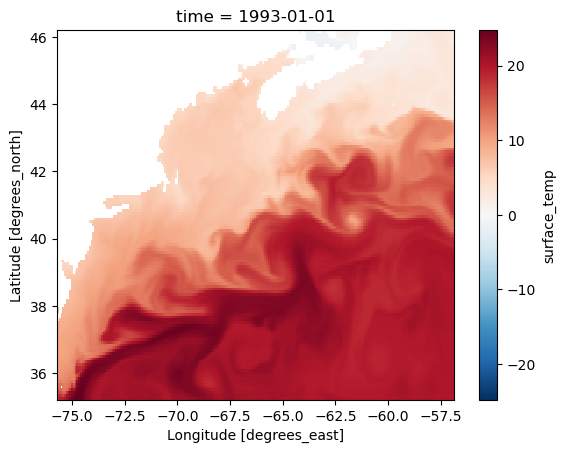

In [ ]:
# Create a mask for bottom depth over 500 meters
# Print dataset information to understand its structure
depth_mask = ds.isel(time = 0).bottom_depth < 500
depth_mask = depth_mask.compute()  # Ensure the mask is computed

# Use the mask to make values NaN where the condition is not met for bottom variables
# Note: The dataset is assumed to have a 'bottom_depth' variable
# Create a copy of the dataset to avoid modifying the original
ds_masked = ds.copy(deep=True)  
ds_masked["bottom_temp"] = ds.bottom_temp.where(depth_mask)
ds_masked["bottom_sal"] = ds.bottom_sal.where(depth_mask)

# Plot to confirm surface is still there, but bottom is masked - good
#ds_masked.bottom_temp.isel(time = 0).plot()
#ds_masked.bottom_sal.isel(time = 0).plot()
ds_masked.surface_temp.isel(time = 0).plot()

### Load the Shapefiles to Mask

Shapefiles found: ['../local_data/ECON_shapefiles/haddock_GB.geojson', '../local_data/ECON_shapefiles/epu_SS.geojson', '../local_data/ECON_shapefiles/epu_GOM.geojson', '../local_data/ECON_shapefiles/epu_MAB.geojson', '../local_data/ECON_shapefiles/yellowtail_SNE.geojson', '../local_data/ECON_shapefiles/yellowtail_GB.geojson', '../local_data/ECON_shapefiles/haddock_GOM.geojson', '../local_data/ECON_shapefiles/yellowtail_GOM.geojson', '../local_data/ECON_shapefiles/epu_GB.geojson']


<Axes: >

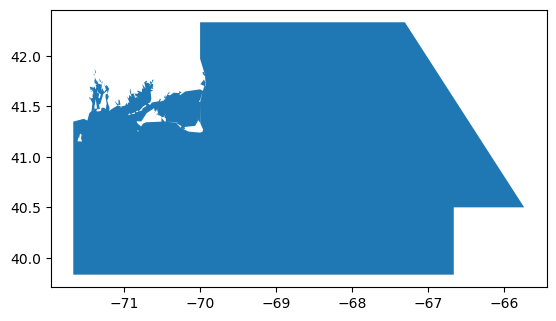

In [81]:
# Path to local shapefile
shapefile_path = "../local_data/ECON_shapefiles"

# Make a list of shapefiles in the directory
shapefile_list = [os.path.join(shapefile_path, f) for f in os.listdir(shapefile_path) if f.endswith('.geojson')]

# Print the list of shapefiles to verify
print("Shapefiles found:", shapefile_list)





# # Load shapefiles in list using geopandas
# Load the shapefiles into a list of GeoDataFrames
shapefiles = []
for file in shapefile_list:
    try:
        shp = gpd.read_file(file)
        # Set the name of the shapefile to its filename without extension
        # add as geodataframe field
        if 'name' not in shp.columns:
            shp['name'] = os.path.splitext(os.path.basename(file))[0].replace(".geojson", "")
        else:
            # If 'name' already exists, update it
            shp['name'] = os.path.splitext(os.path.basename(file))[0].replace(".geojson", "")
        # Add to the list of shapefiles
        shapefiles.append(shp)
    except Exception as e:
        print(f"Error loading {file}: {e}")

# # Check one:
# shapefiles[0]

# Plot the shapefiles to verify they loaded correctly
shapefiles[0].plot()

## Crop Each Shapefile, Produce a Timeseries:

For each shapefile we want the surface and bottom salinity as a daily timeseries.

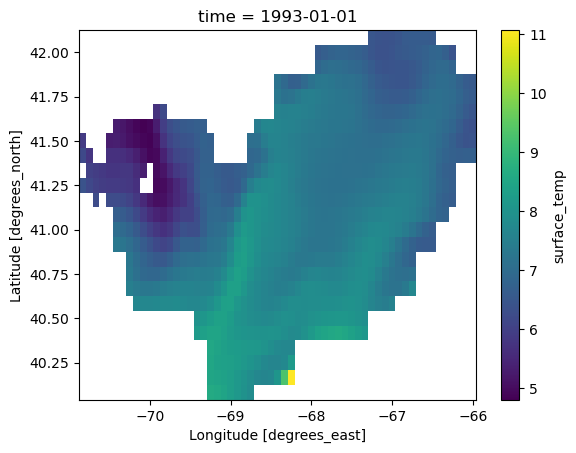

In [88]:
# Create a region mask function to mask the dataset with the shapefiles
def create_region_mask(ds, poly, poly_name=None):

    # Create a region mask from the shapefiles
    regions = regionmask.Regions(
        poly.geometry, 
        name = poly_name if poly_name else poly.name.iloc[0])
    
    # Apply the mask to for things within the region
    interior_mask = regions.mask(ds_masked.longitude, ds.latitude)

    # Note: The mask is applied to the longitude and latitude coordinates of the dataset
    masked_ds = ds.where(
        interior_mask == 0, 
        drop=True)
    
    return masked_ds


# Create the region mask using the shapefiles
masking_test = create_region_mask(ds_masked, shapefiles[8])

# Plot the masked dataset to verify the masking
masking_test.surface_temp.isel(time=0).plot()

In [111]:
# Convert the masked dataset to a dataframe of daily averages
def convert_to_dataframe(masked_ds):
    
    # Get the averages for the whole region
    region_avg = masked_ds.mean(dim = ("latitude", "longitude"))
    
    # Convert to Timeseries Dataframe
    region_ts_df = region_avg.to_dataframe().drop("bottom_depth", axis=1)
    return region_ts_df


# Convert the masked dataset to a DataFrame of daily averages
df_daily_test = convert_to_dataframe(masking_test)

# Print the first few rows of the daily averages DataFrame
df_daily_test.head()

,bottom_temp,surface_temp,surface_sal,bottom_sal
time,,,,
1993-01-01,7.317823,7.149287,32.395343,32.730226
1993-01-02,7.257667,6.976064,32.423399,32.723466
1993-01-03,7.135277,6.825348,32.429266,32.721566
1993-01-04,7.114049,6.818290,32.425853,32.717995
1993-01-05,7.194334,6.913782,32.405171,32.699890


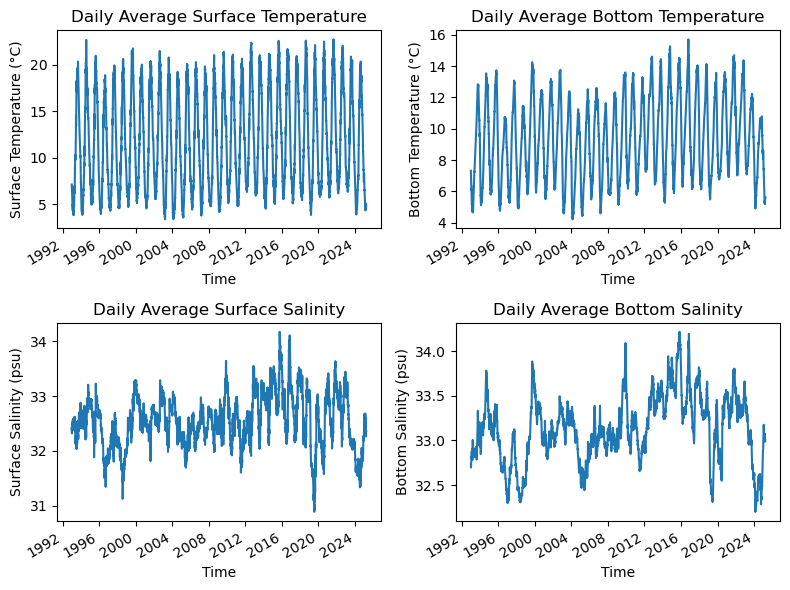

In [112]:
# Plot the daily averages as time series except for bottom_depth
# use a 2x2 grid for plotting
plt.figure(figsize=(8, 6))
# Plot the daily averages for each variable in the DataFrame
plt.subplot(2, 2, 1)
df_daily_test.surface_temp.plot(title="Daily Average Surface Temperature")
plt.xlabel("Time")
plt.ylabel("Surface Temperature (°C)")
plt.subplot(2, 2, 2)
df_daily_test.bottom_temp.plot(title="Daily Average Bottom Temperature")
plt.xlabel("Time")
plt.ylabel("Bottom Temperature (°C)")
plt.subplot(2, 2, 3)
df_daily_test.surface_sal.plot(title="Daily Average Surface Salinity")
plt.xlabel("Time")
plt.ylabel("Surface Salinity (psu)")      
plt.subplot(2, 2, 4)
df_daily_test.bottom_sal.plot(title="Daily Average Bottom Salinity")
plt.xlabel("Time")
plt.ylabel("Bottom Salinity (psu)")
plt.tight_layout()
plt.show()

## Processing Each Shapefile

This last function will produce a dictionary using the "name" attribute of the shapefile as the dictionary keys. 

In [113]:
# Loop over shapefiles and create a region mask for each, then convert to DataFrame
def process_shapefiles(shapefiles, ds):

    # Create a dictionary to hold DataFrames for each region
    region_dataframes = {}
    
    for shp in shapefiles:
        poly_name = shp.name[0]  # Get the name of the shapefile
        masked_ds = create_region_mask(ds, shp)
        region_df = convert_to_dataframe(masked_ds)
        # Store the DataFrame in the dictionary with the region name as the key
        region_dataframes[poly_name] = region_df
    
    return region_dataframes

In [114]:
# Process the timeseries for all shapefiles
region_timeseries = process_shapefiles(shapefiles, ds_masked)

In [115]:
# Check one of them
region_timeseries["epu_GOM"]

,bottom_temp,surface_temp,surface_sal,bottom_sal
time,,,,
1993-01-01,7.167609,6.290488,32.315494,33.583047
1993-01-02,7.156395,6.221390,32.359185,33.577315
1993-01-03,7.135329,6.125108,32.361422,33.572924
1993-01-04,7.145155,6.144460,32.362301,33.576608
1993-01-05,7.179939,6.247637,32.355398,33.590756
...,...,...,...,...
2025-03-21,6.836707,4.521853,32.497067,33.826716
2025-03-22,6.843943,4.491722,32.503534,33.828040
2025-03-23,6.848444,4.408987,32.497402,33.829436


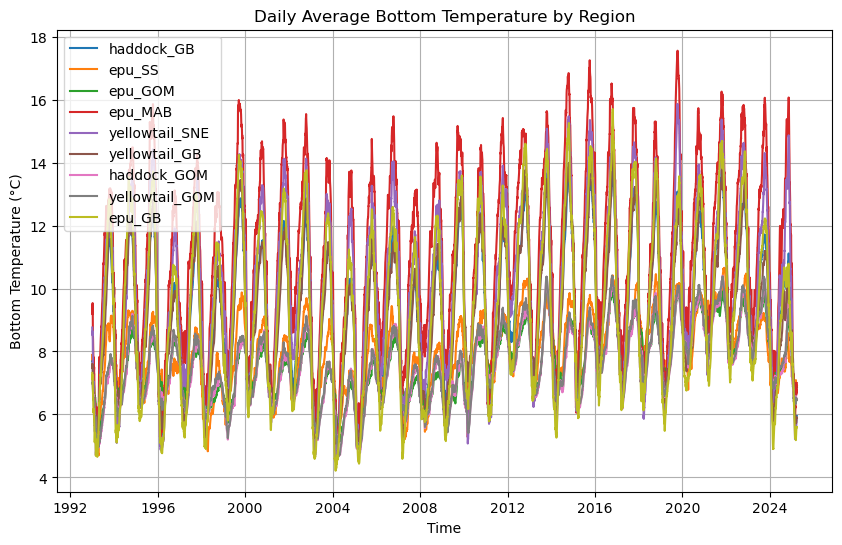

In [116]:
# Plot the surface temperature of each region on one figure
plt.figure(figsize=(10, 6))
for region_name, region_df in region_timeseries.items():
    plt.plot(region_df.index, region_df.bottom_temp, label=region_name)
plt.title("Daily Average Bottom Temperature by Region")
plt.xlabel("Time")
plt.ylabel("Bottom Temperature (°C)")
plt.legend()
plt.grid()
plt.show()

## Saving as Individual Files

In [118]:
# Save each region's DataFrame to a CSV file with the region name
def save_region_dataframes(region_dataframes, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for region_name, df in region_dataframes.items():
        output_file = os.path.join(output_dir, f"{region_name}_timeseries.csv")
        df.to_csv(output_file)
        print(f"Saved {region_name} timeseries to {output_file}")

# Specify the output directory for saving the DataFrames
output_directory = "../local_data/ECON_region_timeseries"
save_region_dataframes(region_timeseries, output_directory)
# Print completion message
print("All region timeseries DataFrames have been saved successfully.")

Saved haddock_GB timeseries to ../local_data/ECON_region_timeseries/haddock_GB_timeseries.csv
Saved epu_SS timeseries to ../local_data/ECON_region_timeseries/epu_SS_timeseries.csv
Saved epu_GOM timeseries to ../local_data/ECON_region_timeseries/epu_GOM_timeseries.csv
Saved epu_MAB timeseries to ../local_data/ECON_region_timeseries/epu_MAB_timeseries.csv
Saved yellowtail_SNE timeseries to ../local_data/ECON_region_timeseries/yellowtail_SNE_timeseries.csv
Saved yellowtail_GB timeseries to ../local_data/ECON_region_timeseries/yellowtail_GB_timeseries.csv
Saved haddock_GOM timeseries to ../local_data/ECON_region_timeseries/haddock_GOM_timeseries.csv
Saved yellowtail_GOM timeseries to ../local_data/ECON_region_timeseries/yellowtail_GOM_timeseries.csv
Saved epu_GB timeseries to ../local_data/ECON_region_timeseries/epu_GB_timeseries.csv
All region timeseries DataFrames have been saved successfully.
